Dataset Shape: (301, 9)

First 5 rows of the dataset:
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    

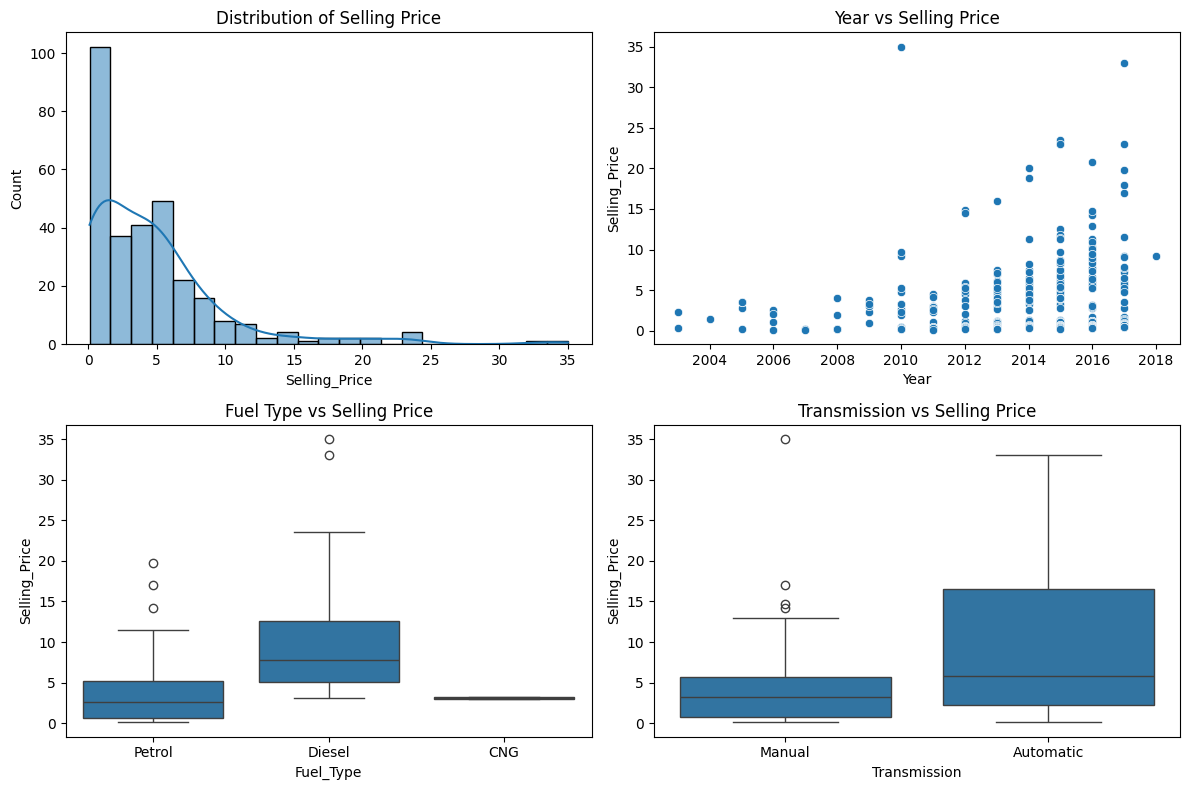

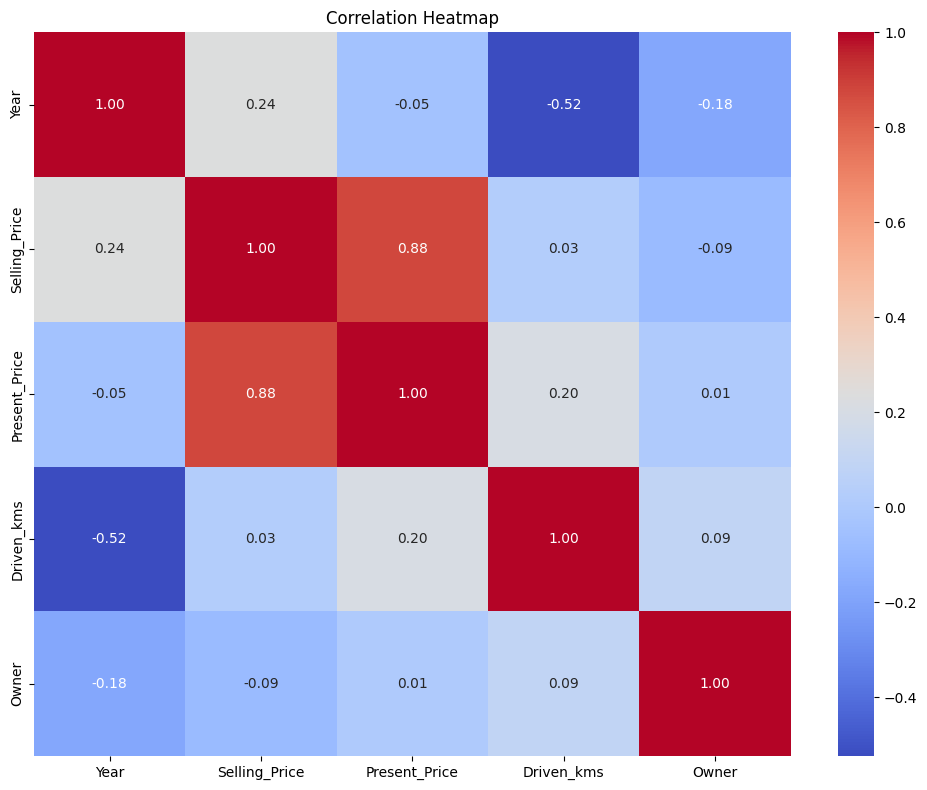

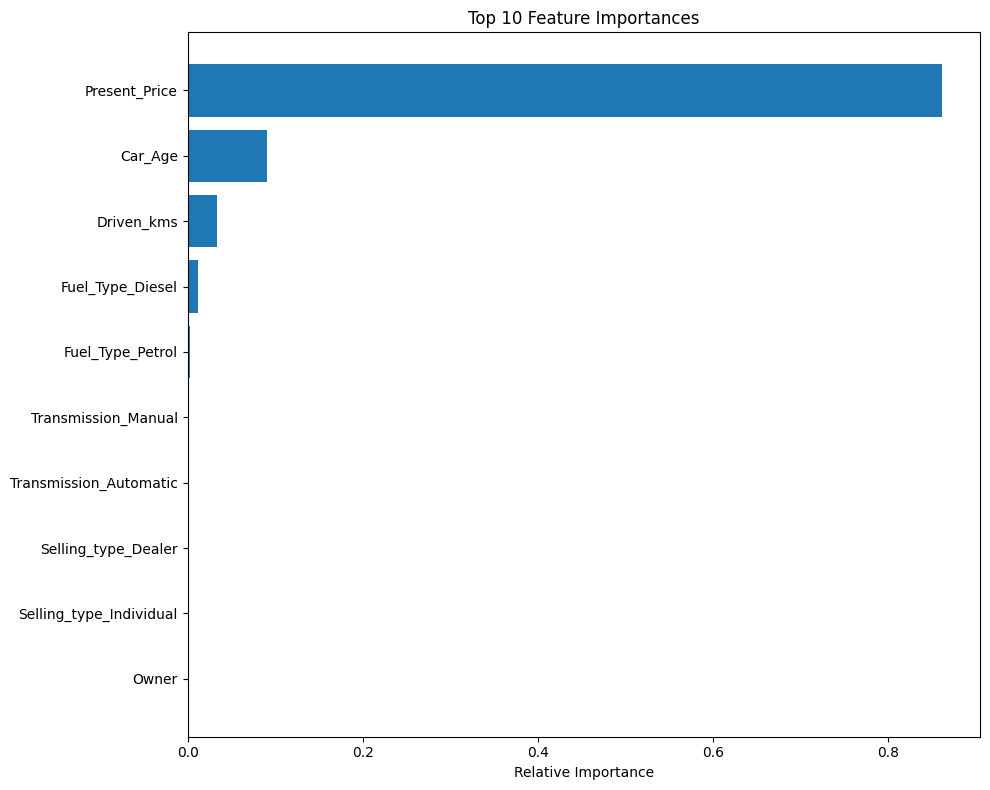

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/car data.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Data Information
print("\nData Information:")
print(df.info())

# Statistical Summary
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(df['Selling_Price'], kde=True)
plt.title('Distribution of Selling Price')

plt.subplot(2, 2, 2)
sns.scatterplot(x='Year', y='Selling_Price', data=df)
plt.title('Year vs Selling Price')

plt.subplot(2, 2, 3)
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=df)
plt.title('Fuel Type vs Selling Price')

plt.subplot(2, 2, 4)
sns.boxplot(x='Transmission', y='Selling_Price', data=df)
plt.title('Transmission vs Selling Price')
plt.tight_layout()
plt.savefig('eda_plots.png')

# Create a correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# Feature Engineering
# Calculate car age
current_year = 2023
df['Car_Age'] = current_year - df['Year']

# Drop unnecessary columns
df = df.drop(['Car_Name', 'Year'], axis=1)

# Print the updated dataset
print("\nDataset after feature engineering:")
print(df.head())

# Prepare data for modeling
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Evaluate each model
results = {}
print("\nModel Evaluation:")
for name, model in models.items():
    # Create and train the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest Model: {best_model_name} with R2 score: {results[best_model_name]['R2']:.4f}")

# Train the best model on the full dataset
best_model = models[best_model_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', best_model)])
best_pipeline.fit(X, y)

# Feature importance (for Random Forest or Gradient Boosting)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get feature names after preprocessing
    ohe_feature_names = list(best_pipeline.named_steps['preprocessor']
                           .named_transformers_['cat']
                           .get_feature_names_out(categorical_cols))
    feature_names = numerical_cols + ohe_feature_names

    # Get feature importances
    importances = best_pipeline.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    plt.figure(figsize=(10, 8))
    plt.title('Top 10 Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

# Example function to predict car price
def predict_car_price(car_details):
    """
    Predict the price of a car based on its details.

    Parameters:
    car_details (dict): Dictionary containing car features

    Returns:
    float: Predicted car price
    """
    # Convert the dictionary to a DataFrame
    car_df = pd.DataFrame([car_details])

    # Calculate car age if year is provided
    if 'Year' in car_df.columns:
        car_df['Car_Age'] = current_year - car_df['Year']
        car_df = car_df.drop('Year', axis=1)

    # Drop Car_Name if present
    if 'Car_Name' in car_df.columns:
        car_df = car_df.drop('Car_Name', axis=1)

    # Predict the price
    predicted_price = best_pipeline.predict(car_df)[0]
    return predicted_price

# Example usage
print("\nExample Prediction:")
example_car = {
    'Present_Price': 10.5,
    'Driven_kms': 15000,
    'Fuel_Type': 'Petrol',
    'Selling_type': 'Dealer',
    'Transmission': 'Manual',
    'Owner': 0,
    'Car_Age': 3  # Current year (2023) - Year of manufacture (2020)
}

predicted_price = predict_car_price(example_car)
print(f"Predicted Price: ₹{predicted_price:.2f} Lakhs")

# Save the model
import joblib
joblib.dump(best_pipeline, 'car_price_prediction_model.pkl')
print("\nModel saved as 'car_price_prediction_model.pkl'")

print("\nCar Price Prediction Model Complete!")